In [3]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [4]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [5]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ridiculously_small'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [6]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (4, 4), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [7]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (504, 56, 56)   out (504, 12, 12)
in (63, 56, 56)   out (63, 12, 12)


In [8]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(504, 56, 56, 1) (504, 12, 12, 1)
(63, 56, 56, 1) (63, 12, 12, 1)


In [9]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

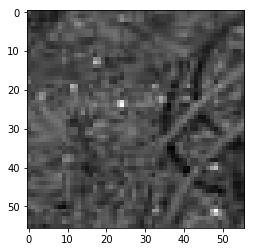

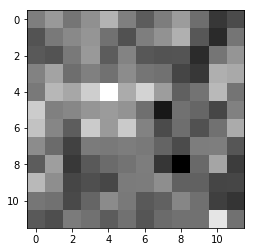

In [10]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [16]:
my_adadelta = keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

In [13]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros(), trainable=False)(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])], trainable=False)(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [27]:
from keras.callbacks import Callback

# taken from https://github.com/keras-team/keras/issues/7874#issuecomment-329347949

class LRPrintCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print(K.eval(lr_with_decay))
        print(K.eval(lr))
        print(K.eval(decay))
        
lr_printer = LRPrintCallback()

In [26]:
# model_version_previous = '0.0.0.2.2_decoder_dense1152_conv32_conv32_conv8_conv1__relu_last_sigmoid_bce_output6x6_lr0.8_trainmore'
# brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')

In [33]:
# brief_ae_previous.get_layer(index=7).get_weights()[0].shape

(512, 1152)

In [37]:
# for i in range(7, 11):
#     print(brief_ae_previous.get_layer(index=i))
#     brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [41]:
brief_ae = load_model('/scratch/image_datasets/2_for_learned_brief/ridiculously_small/brief_ae_0.0.0.3.4_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.001_200moreepochs.h5')
my_adadelta = keras.optimizers.Adadelta(learning_rate=0.01, rho=0.95)
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.1, decay=0.95)
brief_ae.compile(optimizer=my_adadelta, loss="binary_crossentropy")

In [37]:
model_version = '0.0.0.3.5_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12_lr0.001_200moreepochs'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
                steps_per_epoch=x_train.shape[0],
                epochs=1000,
                validation_data=fixed_generator(x_validation, y_validation, batch_size),
                validation_steps=x_validation.shape[0],
                callbacks=[lr_printer]
                )

brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

# brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

Epoch 1/200
504/504 [==============================] - 12s 24ms/step - loss: 0.5835 - val_loss: 0.7055
0.00020842018
0.1
0.95
Epoch 2/200
504/504 [==============================] - 12s 24ms/step - loss: 0.5837 - val_loss: 0.7055
0.0001043188
0.1
0.95
Epoch 3/200
504/504 [==============================] - 12s 24ms/step - loss: 0.5835 - val_loss: 0.7055
6.957006e-05
0.1
0.95
Epoch 4/200
220/504 [============>.................] - ETA: 6s - loss: 0.5834

KeyboardInterrupt: 

predictions: 


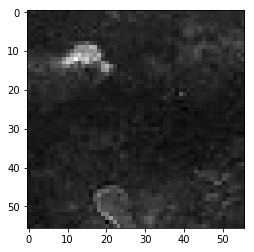

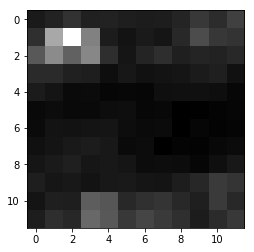

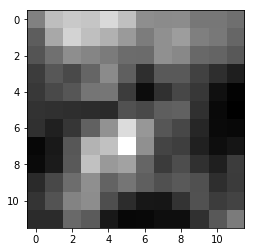

30.179498679935932

 next


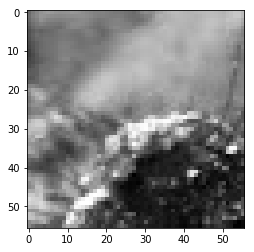

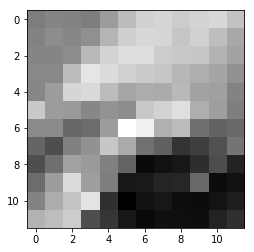

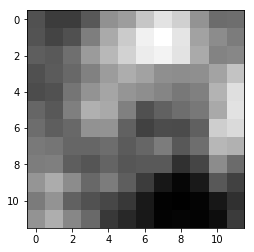

47.85339720547199

 next


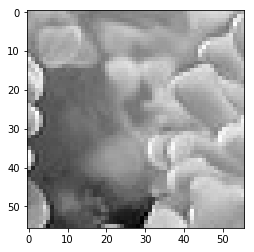

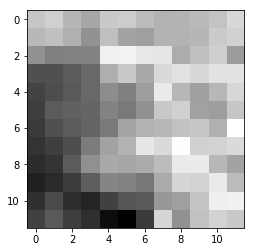

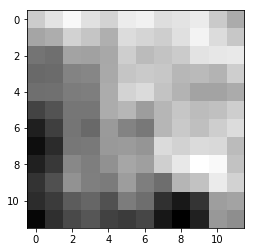

35.196397975087166

 next


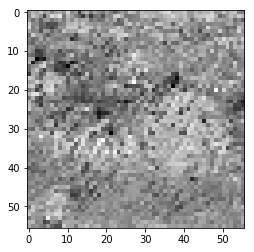

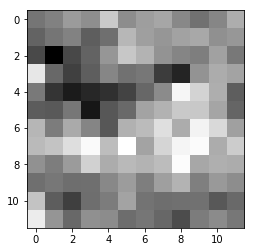

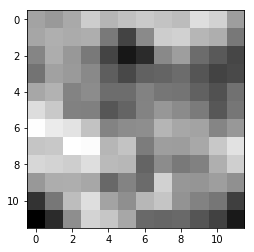

29.24828264862299

 next


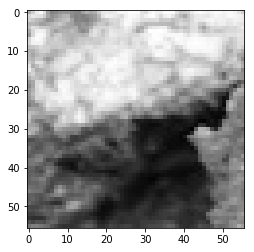

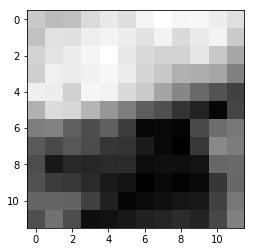

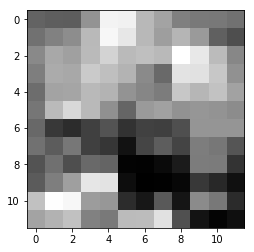

68.12665075063705

 next


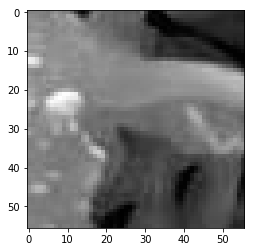

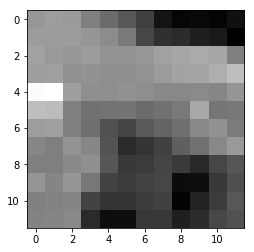

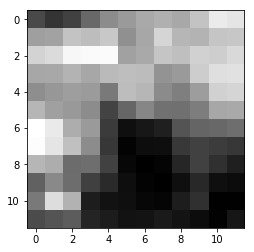

49.88933555781841

 next


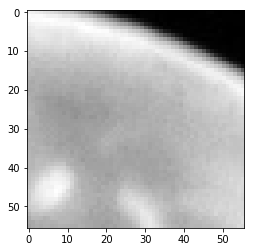

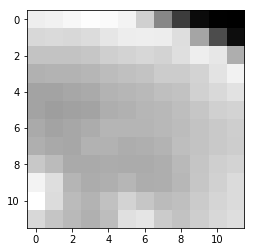

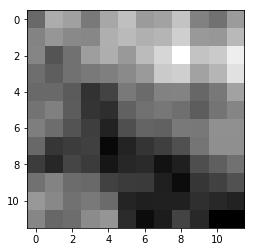

62.84373342990875

 next


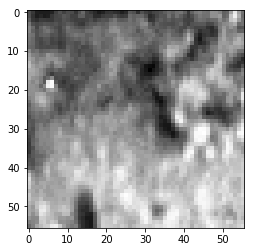

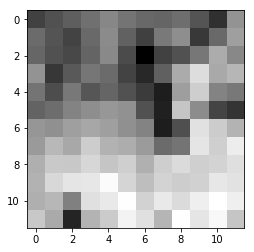

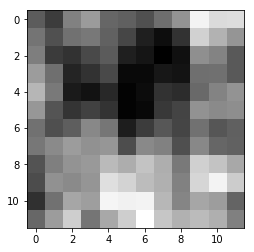

130.25942713022232

 next


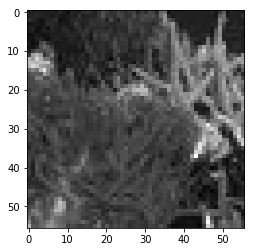

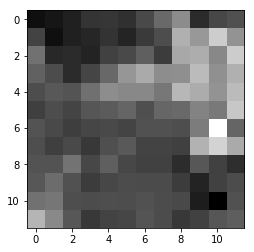

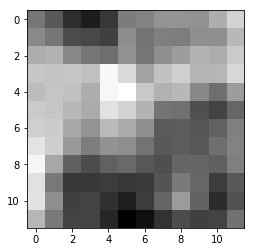

60.902227610349655

 next


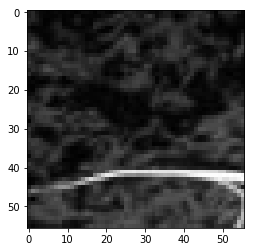

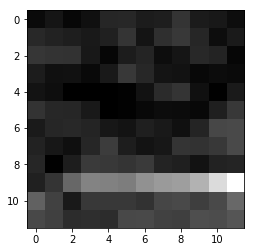

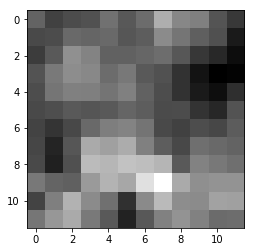

46.805546432733536

 next


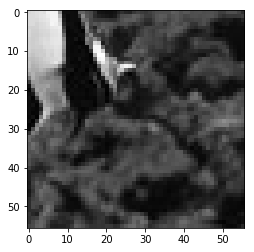

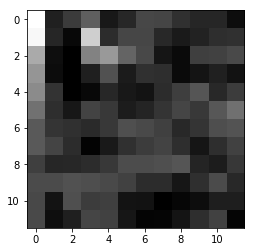

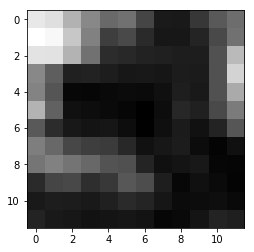

42.225838378071785

 next


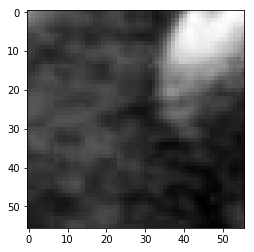

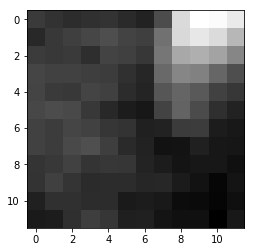

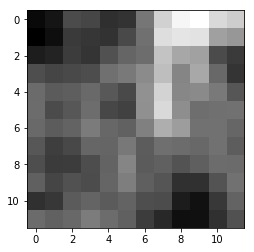

49.03595454990864

 next


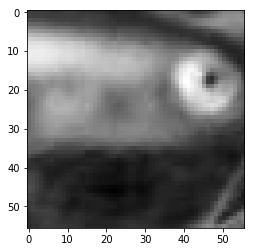

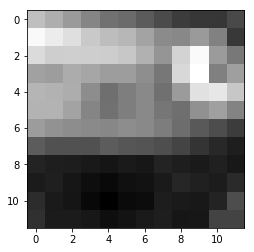

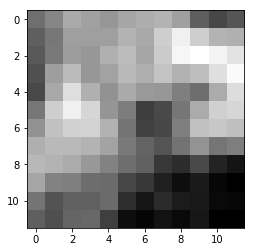

44.178811982274055

 next


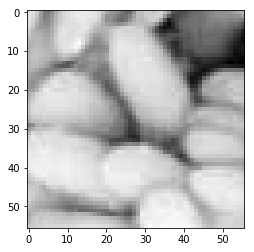

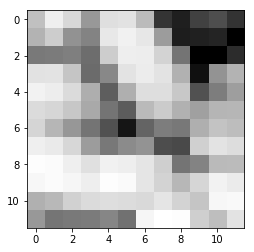

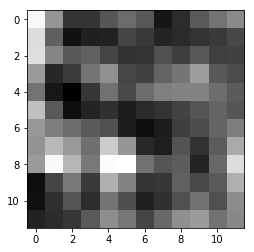

66.86355292797089

 next


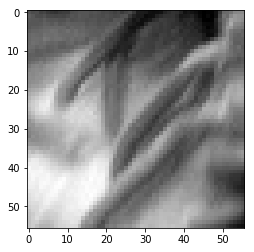

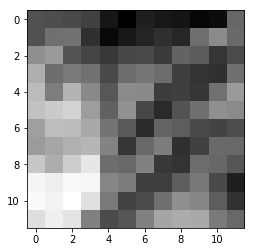

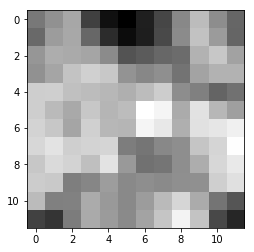

34.049509316682816

 next


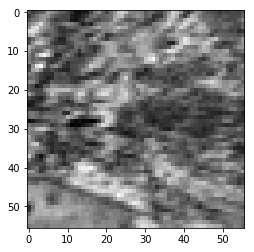

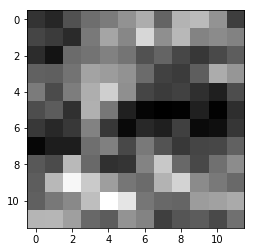

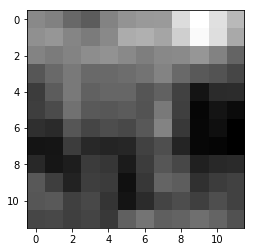

29.986586831510067

 next


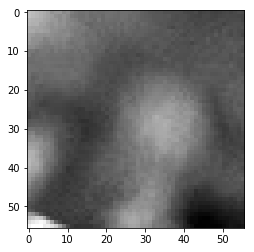

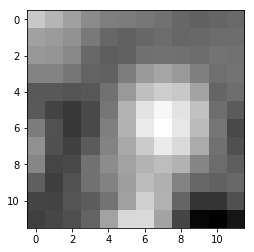

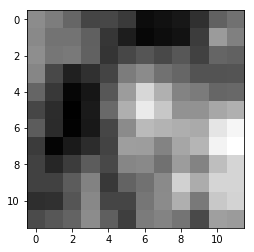

43.39832246303558

 next


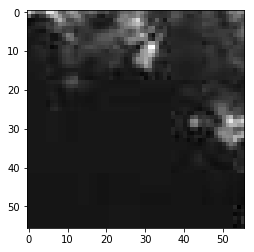

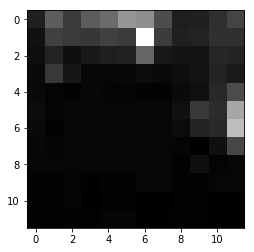

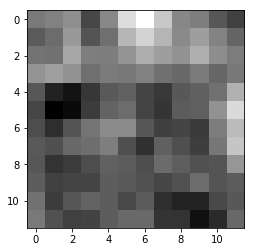

29.557540453970432

 next


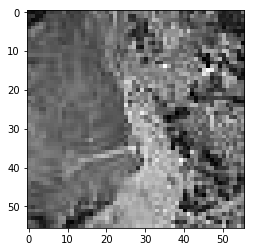

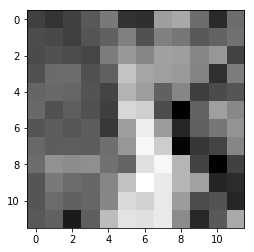

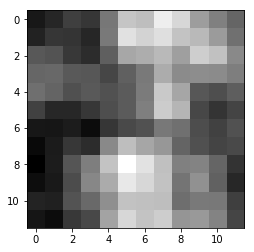

37.744890823960304

 next


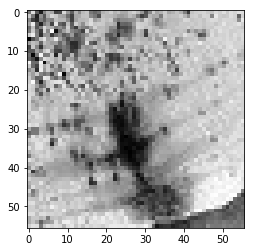

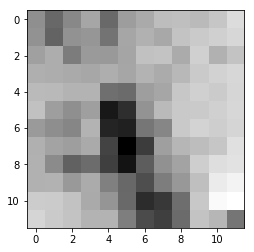

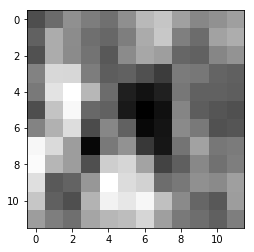

76.28774642944336

 next


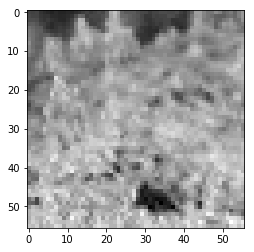

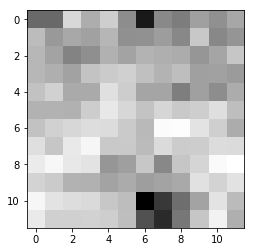

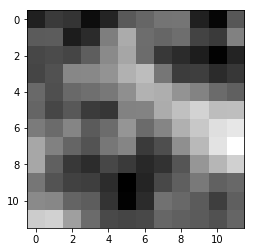

30.075861141085625

 next


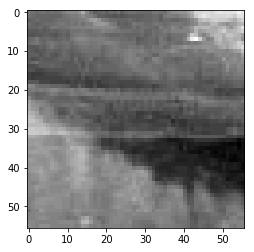

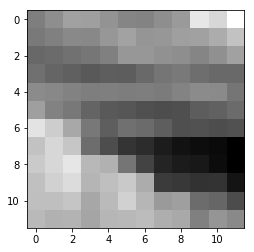

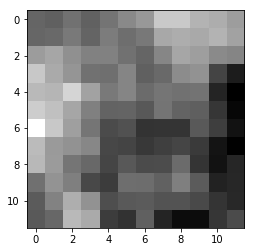

14.140345584601164

 next


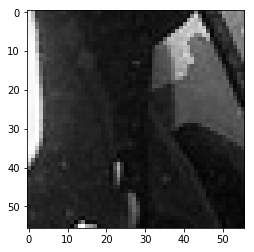

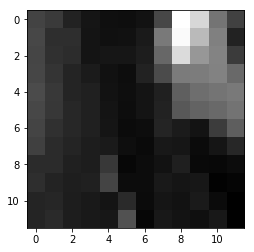

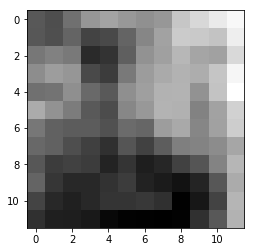

40.001794919371605

 next


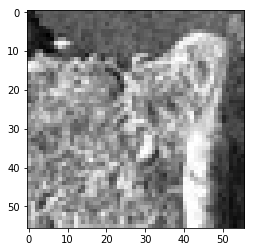

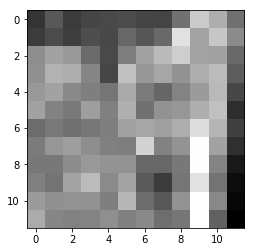

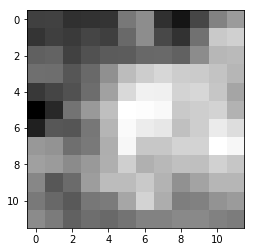

61.68085142970085

 next


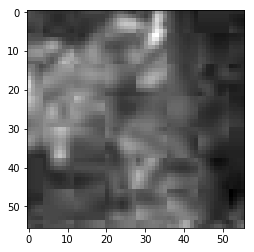

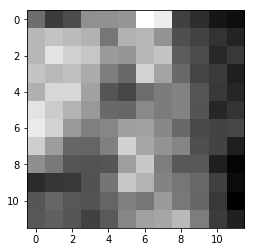

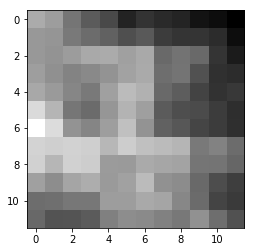

16.8675646930933

 next


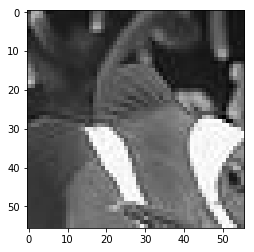

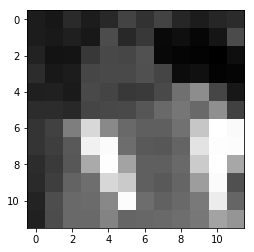

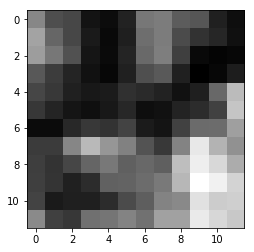

60.62954284250736

 next


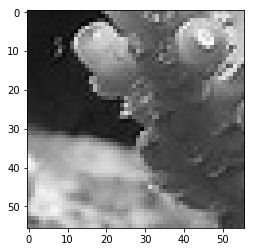

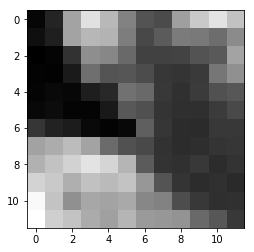

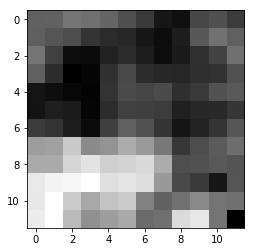

42.378365993499756

 next


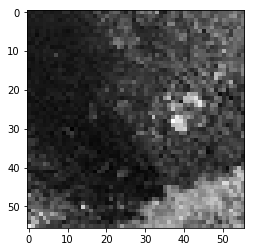

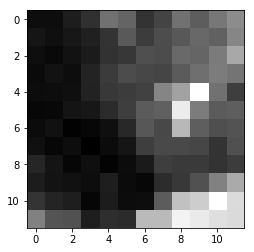

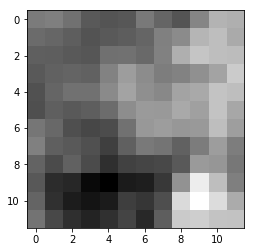

61.15267217159271

 next


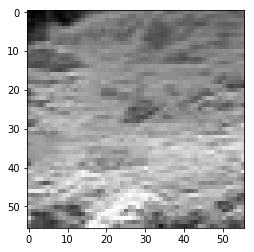

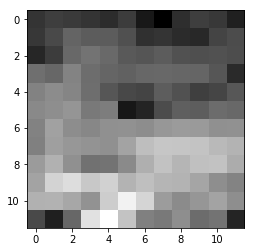

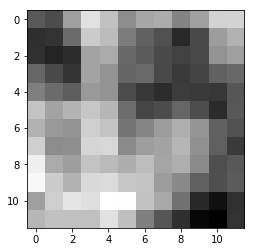

126.44544258713722

 next


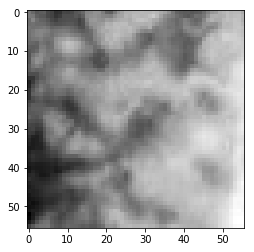

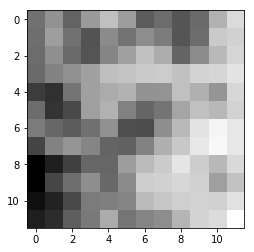

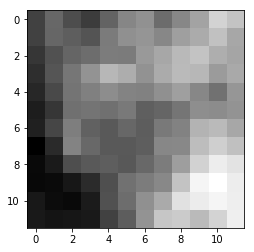

65.33506974577904

 next


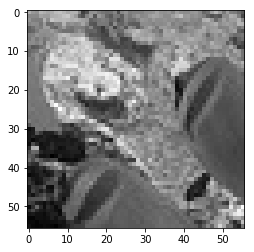

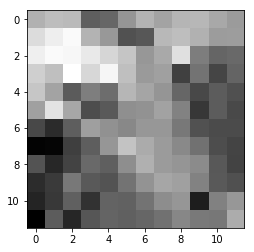

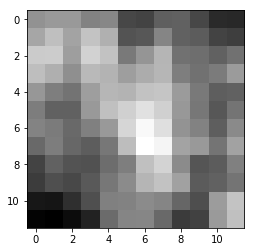

66.63781464099884

 next


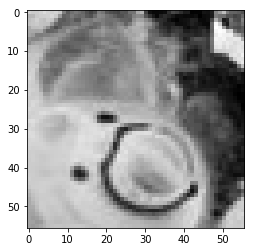

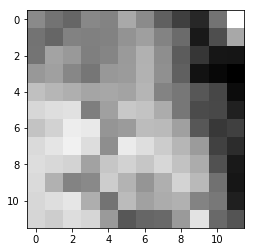

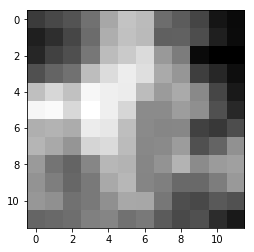

54.582589119672775

 next


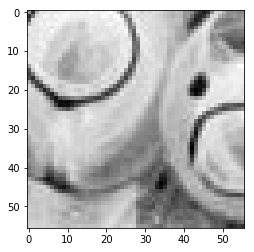

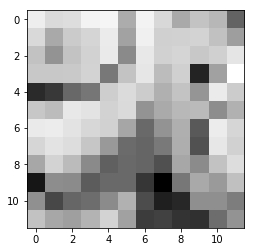

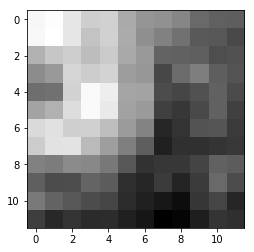

60.951260179281235

 next


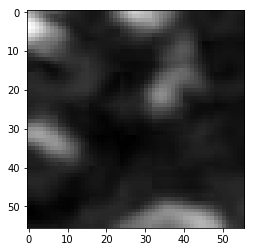

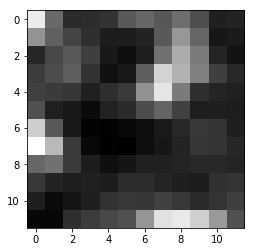

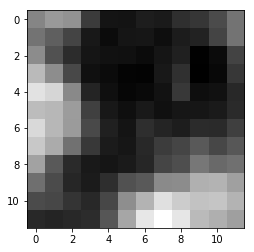

51.358918100595474

 next


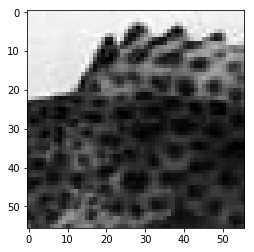

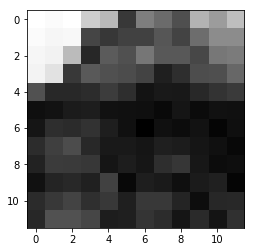

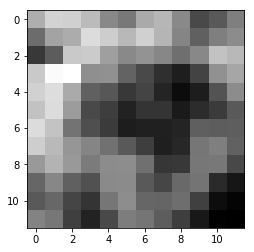

69.83425632119179

 next


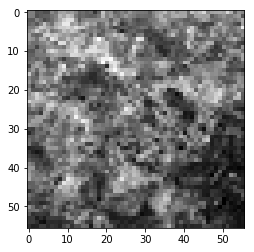

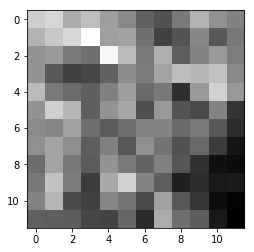

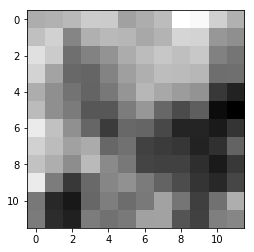

38.39809477329254

 next


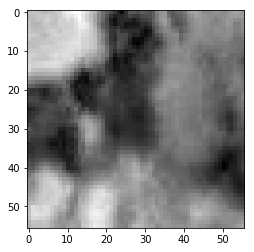

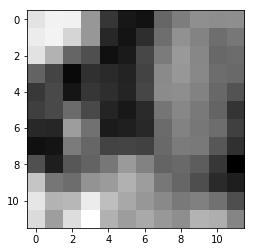

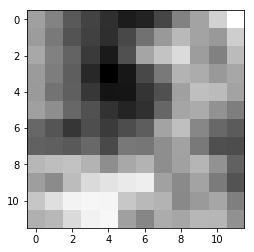

25.518357194960117

 next


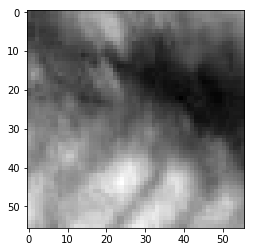

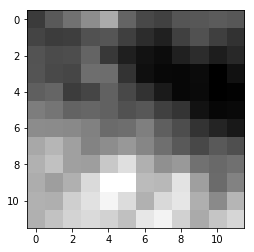

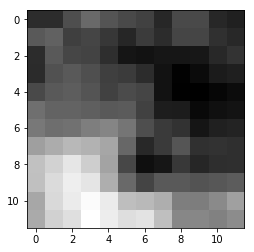

35.61701640486717

 next


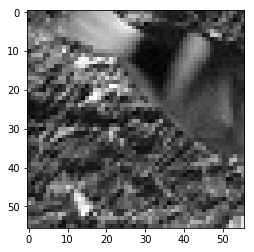

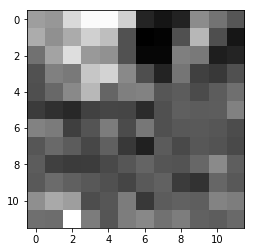

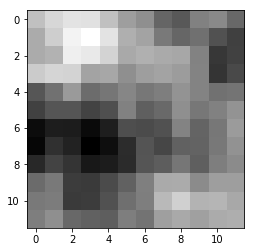

50.67469261586666

 next


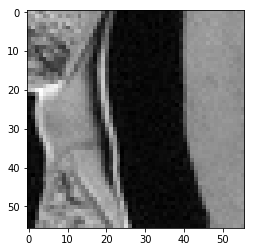

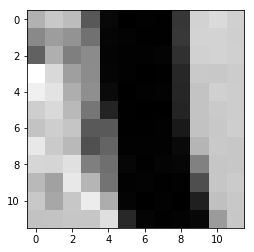

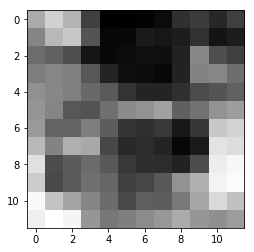

58.214548230171204

 next


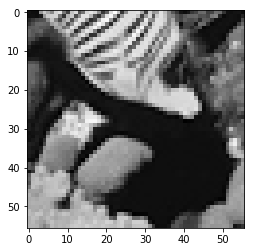

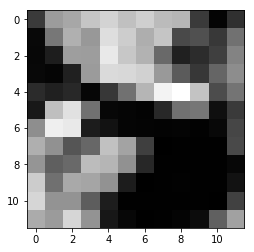

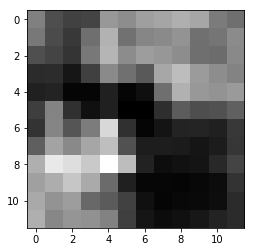

50.588403046131134

 next


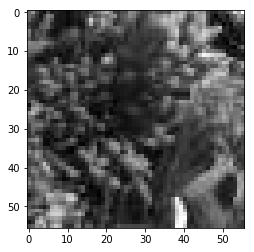

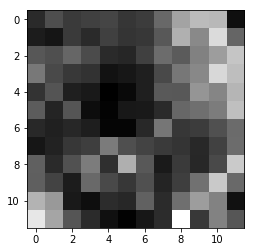

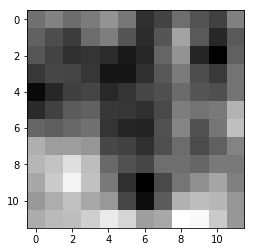

68.68017464876175

 next


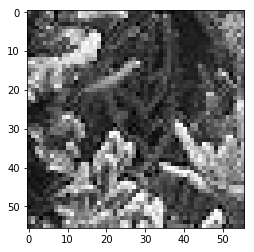

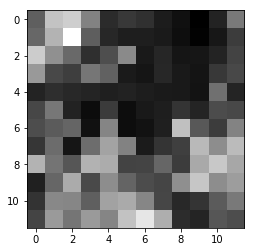

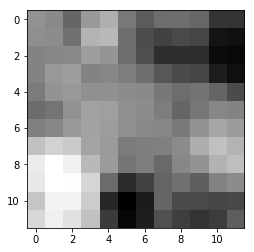

59.752929881215096

 next


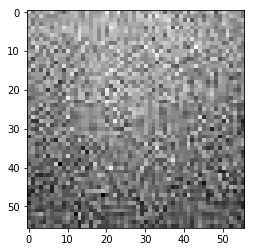

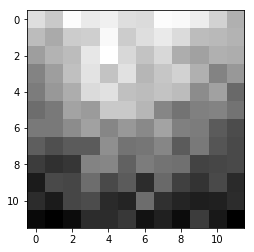

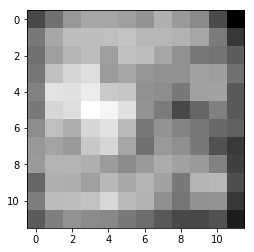

34.923131838440895

 next


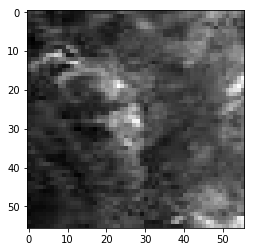

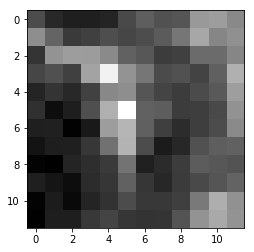

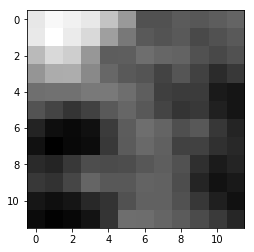

35.12670211493969

 next


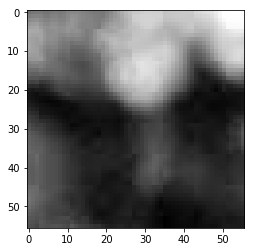

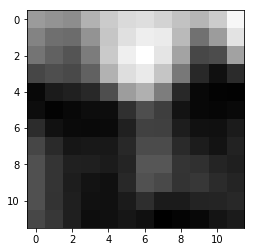

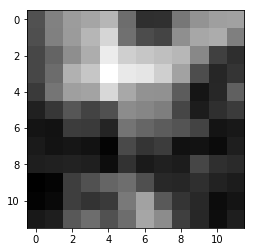

47.57430978119373

 next


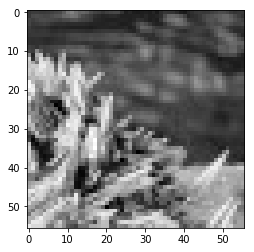

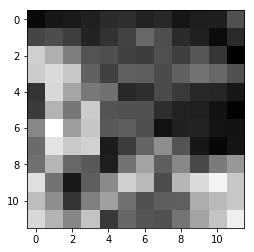

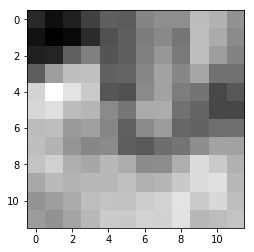

42.474922612309456

 next


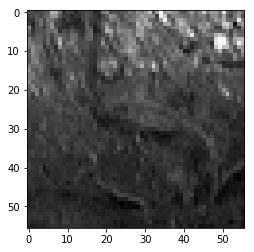

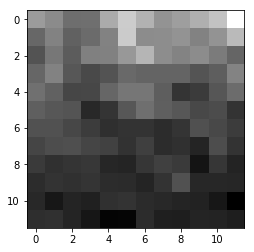

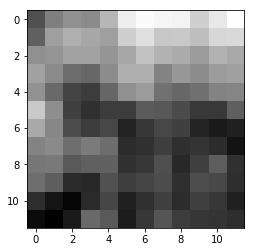

15.592660903930664

 next


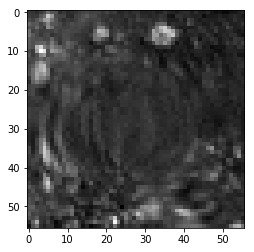

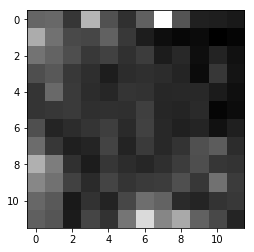

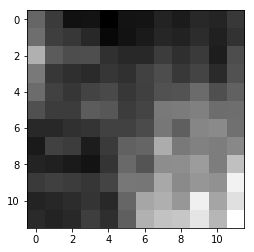

30.57836327701807

 next


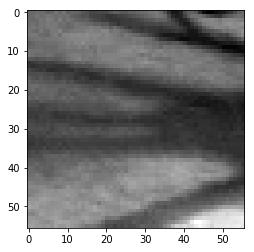

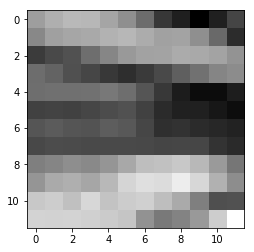

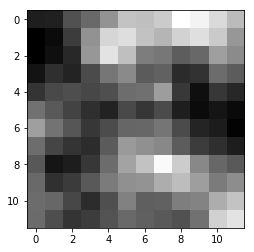

30.708477795124054

 next


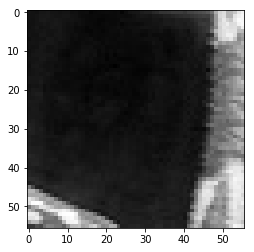

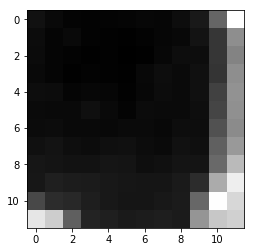

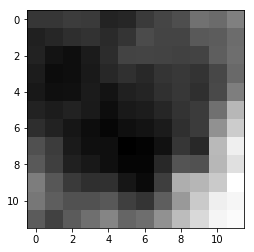

36.307313963770866

 next


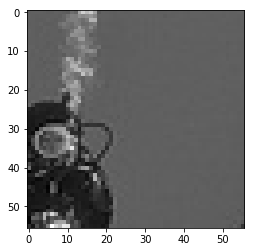

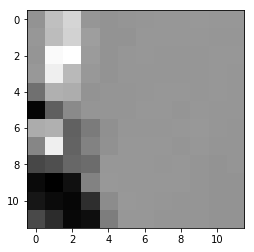

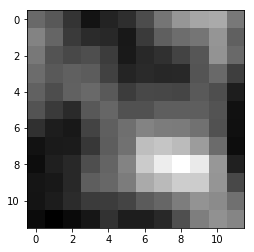

29.499143287539482

 next


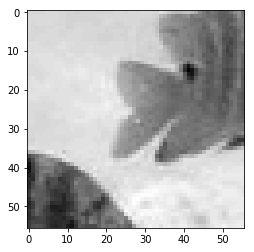

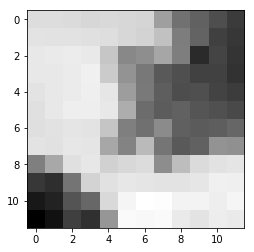

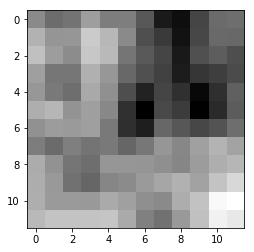

54.71327170729637

 next


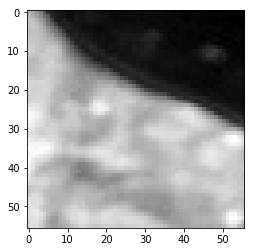

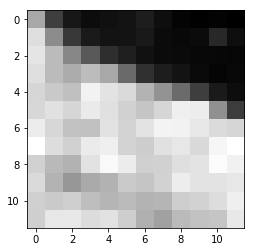

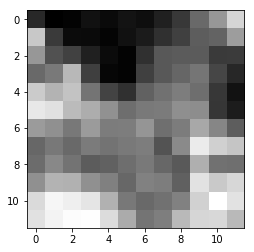

40.72157509624958

 next


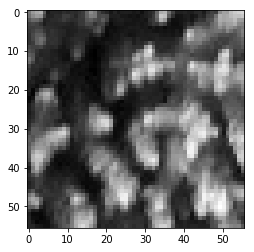

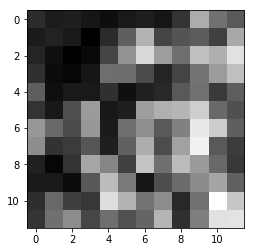

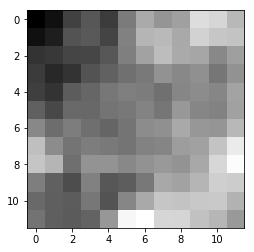

38.356388211250305

 next


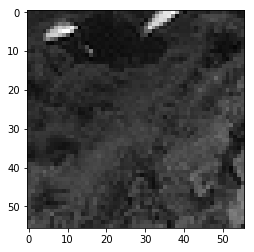

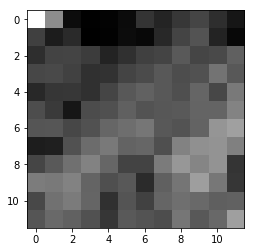

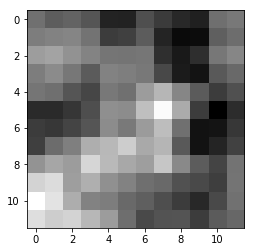

45.66525042057037

 next


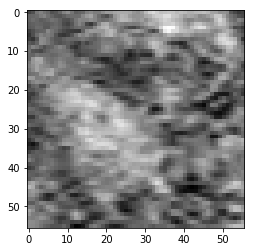

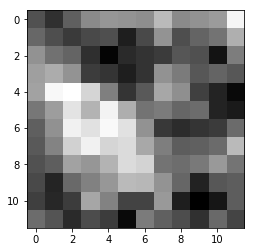

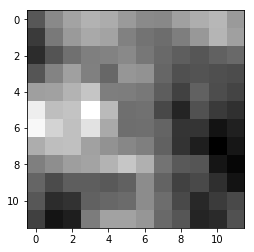

28.820642195641994

 next


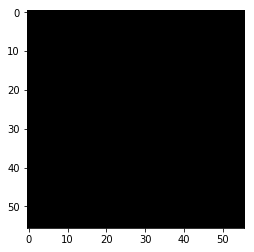

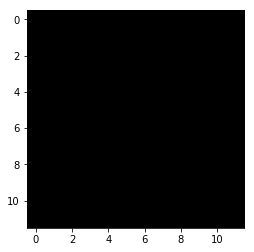

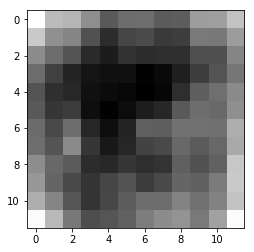

39.28056702017784

 next


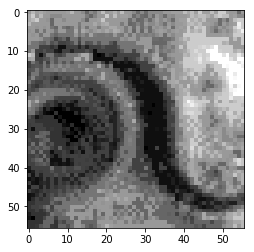

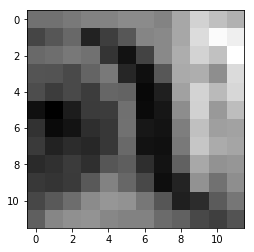

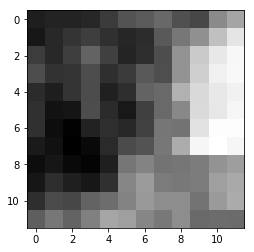

48.51894669234753

 next


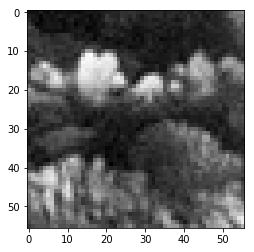

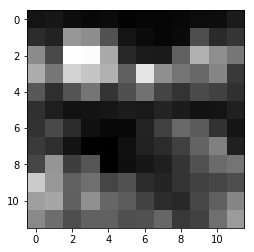

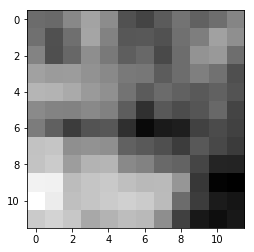

39.997979924082756

 next


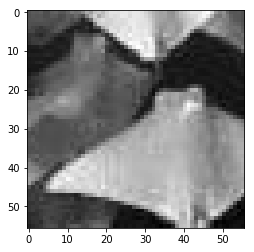

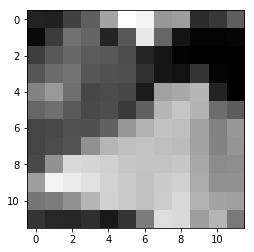

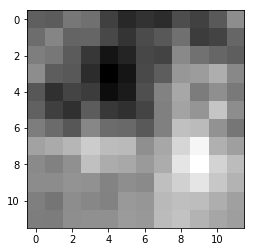

48.170562386512756

 next


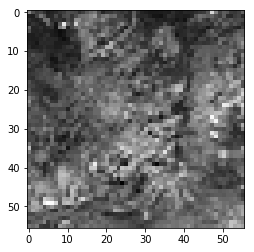

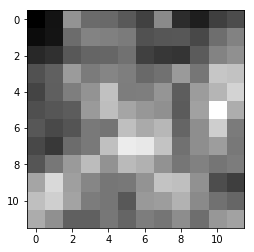

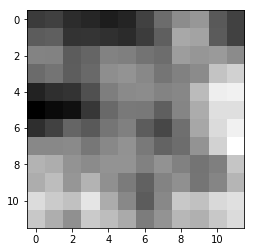

55.9658744931221

 next


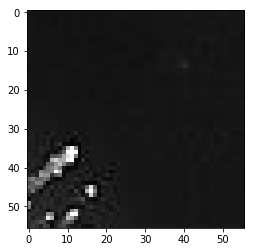

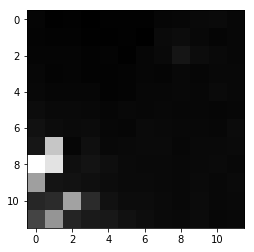

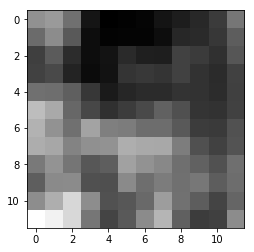

31.44676297903061

 next


In [23]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (4, 4), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((12, 12))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    
    print("\n next")